# GPT-4-Vision-preview

In [1]:
!pip install -U openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.1/463.1 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.59.9
    Uninstalling openai-1.59.9:
      Successfully uninstalled openai-1.59.9


In [2]:
# @title openaiキーの設定
import os
from google.colab import userdata

openai_api_key = userdata.get('OPENAI_API_KEY') # @param {type:"string"}
os.environ['OPENAI_API_KEY'] = openai_api_key

In [ ]:
# @title 質問と画像をリクエストする関数
from openai import OpenAI

client = OpenAI()

def ask_v_question(question, image_url, max_tokens=256):
    response = client.chat.completions.create(
      model="gpt-4o",
      messages=[
        {
          "role": "user",
          "content": [
            {"type": "text", "text": question},
            {
              "type": "image_url",
              "image_url": {
                "url": image_url,
              },
            },
          ],
        }
      ],
      max_tokens=max_tokens,
    )

    return response.choices[0].message.content

## 質問１

https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Day2-2_%2840909714314%29.jpg/500px-Day2-2_%2840909714314%29.jpg
![title](https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Day2-2_%2840909714314%29.jpg/500px-Day2-2_%2840909714314%29.jpg)

In [ ]:
kaminarimon_img_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Day2-2_%2840909714314%29.jpg/500px-Day2-2_%2840909714314%29.jpg"

print(ask_v_question("どこの写真ですか？", kaminarimon_img_url))

これは、東京の浅草にある「雷門」（かみなりもん）です。浅草寺（せんそうじ）の有名な入り口で、大きな提灯が特徴です。観光名所として人気があります。


## 質問2

https://i.ibb.co/6XbhMzS/ui-scribble.jpg

![title](https://i.ibb.co/6XbhMzS/ui-scribble.jpg)

In [ ]:
screenshot_img_url = "https://i.ibb.co/6XbhMzS/ui-scribble.jpg"

response = ask_v_question("このUIをHTMLコードで作成してください。", screenshot_img_url, max_tokens=512)

print(response)

こちらのUIをHTMLとCSSで再現しました。シンプルなスタイルを使用していますので、必要に応じてデザインを調整してください。

```html
<!DOCTYPE html>
<html lang="ja">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>UI Mockup</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            display: flex;
            justify-content: center;
            align-items: center;
            height: 100vh;
            margin: 0;
            background-color: #f0f0f0;
        }
        .container {
            background-color: white;
            padding: 20px;
            box-shadow: 0 0 10px rgba(0, 0, 0, 0.1);
            text-align: center;
            width: 300px;
        }
        .title {
            font-size: 24px;
            margin-bottom: 20px;
        }
        .content {
            background-color: #e0e0e0;
            margin-bottom: 10px;
            padding: 20px;
            height: 100px;
            display: flex;
            justify-co

In [ ]:
from IPython.core.display import display, HTML
display(HTML(response.split("```")[1]))

## 質問3

https://miyoshishipbuilding.co.jp/re/wp-content/uploads/2020/08/BN-jisseki03.jpg

![title](https://miyoshishipbuilding.co.jp/re/wp-content/uploads/2020/08/BN-jisseki03.jpg)

In [ ]:
ship_url = "https://miyoshishipbuilding.co.jp/re/wp-content/uploads/2020/08/BN-jisseki03.jpg"

response = ask_v_question("この写真にはヘルメットの何個が写っていますか？", ship_url, max_tokens=512)

print(response)

写真には2個のヘルメットが写っています。


In [ ]:
ship_url = "https://miyoshishipbuilding.co.jp/re/wp-content/uploads/2020/08/BN-jisseki03.jpg"

prompt = """
Which of the following labels is most appropriate to classify this image?
Candidates: ship building,construction site,truck driving
Label: """

response = ask_v_question(prompt, ship_url, max_tokens=16)

print(response)

ship building


# CLIP (画像分類)

In [ ]:
from PIL import Image
import requests

from transformers import pipeline

In [ ]:
# @title モデルのロードとzeroshot分類のパイプライン定義

checkpoint = "openai/clip-vit-large-patch14"
detector = pipeline(model=checkpoint, task="zero-shot-image-classification")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


https://miyoshishipbuilding.co.jp/re/wp-content/uploads/2020/08/BN-jisseki03.jpg

![title](https://miyoshishipbuilding.co.jp/re/wp-content/uploads/2020/08/BN-jisseki03.jpg)

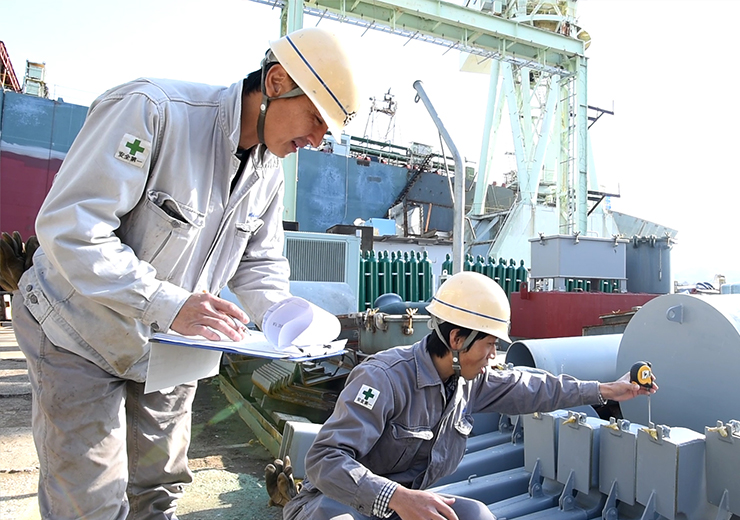

In [ ]:
# @title 推論に利用する画像読み込み
url = "https://miyoshishipbuilding.co.jp/re/wp-content/uploads/2020/08/BN-jisseki03.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
# @title 分類の候補となるラベルを指定
candidate_labels = ["ship building", "construction site", "truck driving"]

In [ ]:
# @title 分類結果の確認
predictions = detector(image, candidate_labels=candidate_labels)
print(predictions)

[{'score': 0.9997846484184265, 'label': 'ship building'}, {'score': 0.00020476679492276162, 'label': 'construction site'}, {'score': 1.0589856174192391e-05, 'label': 'truck driving'}]


In [ ]:
# @title 候補ラベルを自然な文に拡張
def get_prompt(label):
  return f"They are working on {label} in this image."

prompts = [get_prompt(label) for label in candidate_labels]
predictions = detector(image, candidate_labels=prompts)
print(predictions)

[{'score': 0.9994221925735474, 'label': 'They are working on ship building in this image.'}, {'score': 0.0003949489910155535, 'label': 'They are working on truck driving in this image.'}, {'score': 0.00018289368017576635, 'label': 'They are working on construction site in this image.'}]


# XCLIP

In [ ]:
# @title 動画読み込み・ダウンロードのためのライブラリインストール
!pip install pytubefix decord

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 8.5 MB/s eta 0:00:00


In [ ]:
# @title 必要なライブラリの読み込み
from decord import VideoReader, cpu
import numpy as np
from PIL import Image
from pytubefix import YouTube
import torch
from transformers import XCLIPProcessor, XCLIPModel

In [ ]:
# @title モデルの読み込み

model_name = "microsoft/xclip-base-patch32"
processor = XCLIPProcessor.from_pretrained(model_name)
model = XCLIPModel.from_pretrained(model_name)

preprocessor_config.json:   0%|          | 0.00/309 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/965 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/786M [00:00<?, ?B/s]

In [ ]:
# @title 動画の読み込み

youtube_url = 'http://youtube.com/watch?v=u2s7YdQ7Gzs'
yt = YouTube(youtube_url)

streams = yt.streams.filter(file_extension='mp4')
file_path = streams[0].download()

In [ ]:
# @title 動画から画像をサンプリングして入力を作成

videoreader = VideoReader(file_path, num_threads=1, ctx=cpu(0))

# sample 8 frames
unit_frame = 10
videoreader.seek(30)
indices = np.arange(0, 8 * unit_frame, unit_frame)
video = videoreader.get_batch(indices).asnumpy()
print(video.shape)

Image.fromarray(video[0])

NameError: name 'VideoReader' is not defined

In [ ]:
# @title 分類する候補を入力
candidate_labels = ["programming course", "eating spaghetti", "working in a logistics warehouse"]

In [ ]:
# @title 推論実施
inputs = processor(text=candidate_labels, videos=list(video), return_tensors="pt", padding=True)

# forward pass
with torch.no_grad():
    outputs = model(**inputs)

probs = outputs.logits_per_video.softmax(dim=1)
probs

tensor([[0.0054, 0.0032, 0.9915]])

# BLIP (画像に対して質問応答）

In [ ]:
# @title 必要なライブラリのインストール.
!pip install -qU transformers==4.33.3 accelerate bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.2/333.2 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.2.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.33.3 which is incompatible.


In [ ]:
import torch
import requests
from PIL import Image
from transformers import Blip2Processor, Blip2ForConditionalGeneration

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [ ]:
# @title モデルの読み込み
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", load_in_4bit=True, device_map="auto")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/127k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

https://miyoshishipbuilding.co.jp/re/wp-content/uploads/2020/08/BN-jisseki03.jpg

![title](https://miyoshishipbuilding.co.jp/re/wp-content/uploads/2020/08/BN-jisseki03.jpg)

In [ ]:
# @title 画像URLと質問に対して回答する関数
def ask_question(url, question):
    raw_image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

    inputs = processor(raw_image, question, return_tensors="pt").to("cuda", torch.float16)

    out = model.generate(**inputs, max_length=64)
    return processor.decode(out[0], skip_special_tokens=True).strip()

In [ ]:
url = "https://miyoshishipbuilding.co.jp/re/wp-content/uploads/2020/08/BN-jisseki03.jpg"

question = "Question: how many people are in the picture? Answer:"
ask_question(url, question)

/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:452: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


'there are two people in the picture'

In [ ]:
question = "Question: Where are the people in this picture? Answer:"

ask_question(url, question)

'They are working on the ship'

# GroundingSAM

In [ ]:
%cd /content

/content


In [ ]:
# @title GroundingDINOのインストール
%%bash

cd /content
git clone "https://github.com/IDEA-Research/GroundingDINO.git"
cd /content/GroundingDINO
git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
pip install -q -e .

Cloning into 'GroundingDINO'...


In [ ]:
# @title モデルのダウンロード
%%bash

cd /content
mkdir -p weights
cd weights
wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

In [ ]:
%cd /content/GroundingDINO

/content/GroundingDINO


In [ ]:
# @title 画像の読み込み
!wget https://miyoshishipbuilding.co.jp/re/wp-content/uploads/2020/08/BN-jisseki03.jpg

--2024-11-21 09:01:40--  https://miyoshishipbuilding.co.jp/re/wp-content/uploads/2020/08/BN-jisseki03.jpg
Resolving miyoshishipbuilding.co.jp (miyoshishipbuilding.co.jp)... 183.181.97.32
Connecting to miyoshishipbuilding.co.jp (miyoshishipbuilding.co.jp)|183.181.97.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 315205 (308K) [image/jpeg]
Saving to: ‘BN-jisseki03.jpg’

BN-jisseki03.jpg    100%[===================>] 307.82K  1.09MB/s    in 0.3s    

2024-11-21 09:01:41 (1.09 MB/s) - ‘BN-jisseki03.jpg’ saved [315205/315205]



In [ ]:
import os
from typing import List

import cv2
from google.colab.patches import cv2_imshow
import supervision as sv
import torch

from groundingdino.util.inference import Model

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
# @title モデルのロード

GROUNDING_DINO_CONFIG_PATH = os.path.join("/content", "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH))
GROUNDING_DINO_CHECKPOINT_PATH = os.path.join("/content", "weights", "groundingdino_swint_ogc.pth")
print(GROUNDING_DINO_CHECKPOINT_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH))
grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/content/GroundingDINO/groundingdino/util/inference.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implic

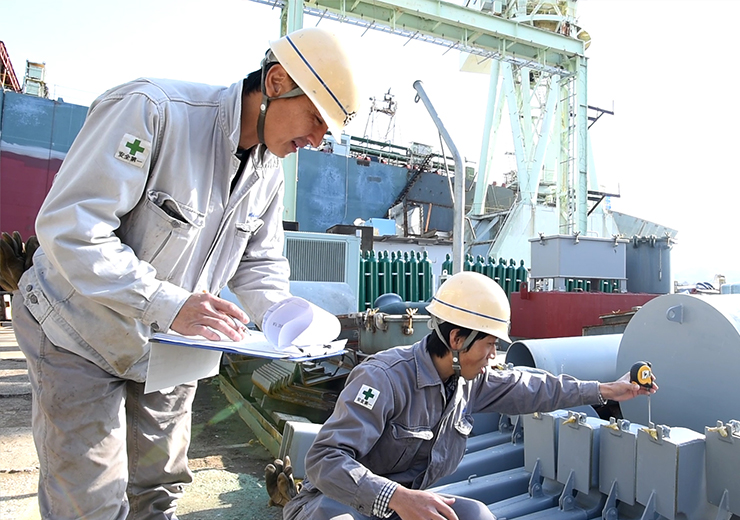

In [ ]:
# @title 画像の読み込み
SOURCE_IMAGE_PATH = "BN-jisseki03.jpg"
image = cv2.imread(SOURCE_IMAGE_PATH)
cv2_imshow(image)

In [ ]:
# @title 推論の設定

BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25
CLASSES = ["helmet", "person", "tape measure"]
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

In [ ]:
# @title 推論実行
detections = grounding_dino_model.predict_with_classes(
    image=image,
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_THRESHOLD,
    text_threshold=TEXT_THRESHOLD
)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/content/GroundingDINO/groundingdino/models/GroundingDINO/transformer.py:862: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast

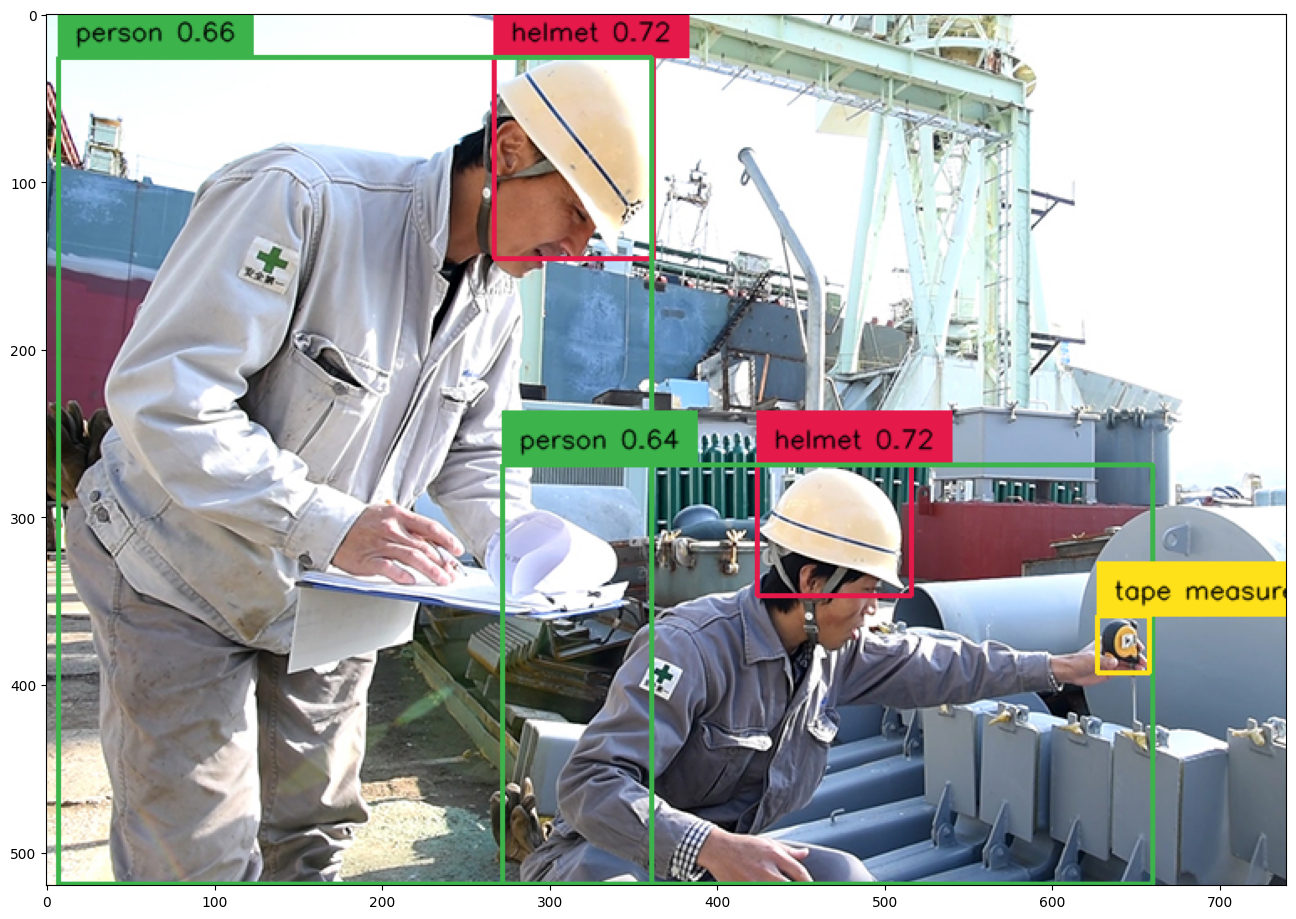

In [ ]:
# @title 推論結果を画像に描画
box_annotator = sv.BoxAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

In [ ]:
# @title 自然文を入力したときの検出例
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25
caption = "The person standing with a white shirt and holding a clipboard."

detections, labels = grounding_dino_model.predict_with_caption(
    image=image,
    caption=caption,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

## SAM

In [ ]:
# @title SAMのインストール
%%bash

cd $HOME
python -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
pip uninstall -y supervision
pip install -q roboflow supervision==0.6.0

In [ ]:
# @title モデルのダウンロード

%%bash

cd $HOME/weights
wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [ ]:
import numpy as np
from segment_anything import sam_model_registry, SamPredictor


In [ ]:
# @title モデル読み込み
SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

SAM_ENCODER_VERSION = "vit_h"

sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

In [ ]:
# @title 推論に使用する関数
def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

In [ ]:
# @title 検出したbboxに対するセグメンテーションの推論実行
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)

In [ ]:
# @title セグメンテーションの結果を描画
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()

annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_image, (16, 16))